# 한국어와 NLTK, Gensim의 만남

In [1]:
from konlpy.tag import Twitter

## 1. Data preprocessing

In [2]:
def read_data(filename):
    with open(filename, 'r', encoding='UTF') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

train_data = read_data('nsmc-master/ratings_train.txt')
test_data = read_data('nsmc-master/ratings_test.txt')

In [3]:
print(len(train_data))      # nrows: 150000
print(len(train_data[0]))   # ncols: 3
print(len(test_data))       # nrows: 50000
print(len(test_data[0]))     # ncols: 3

150000
3
50000
3


In [4]:
pos_tagger = Twitter()
def tokenize(doc):
    # norm, stem은 optional
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

In [5]:
from pprint import pprint
pprint(train_docs[0])

(['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증/Noun',
  '나다/Verb',
  '목소리/Noun'],
 '0')


## 2. Data exploration

In [6]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


In [7]:
import nltk
text = nltk.Text(tokens, name='NMSC') # .text()는 Exploration할 때 편함.
print(text)

<Text: NMSC>


In [8]:
print(len(text.tokens))                 # returns number of tokens
print(len(set(text.tokens)))            # returns number of unique tokens
pprint(text.vocab().most_common(10))    # returns frequency distribution

2194536
48765
[('./Punctuation', 68630),
 ('영화/Noun', 51365),
 ('하다/Verb', 50281),
 ('이/Josa', 39123),
 ('보다/Verb', 34764),
 ('의/Josa', 30480),
 ('../Punctuation', 29055),
 ('에/Josa', 27108),
 ('가/Josa', 26696),
 ('을/Josa', 23481)]


In [9]:
from matplotlib import font_manager, rc
font_fname = 'c:/windows/fonts/gulim.ttc'     # A font of your choice
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

C:\Users\master\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['Gulim'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


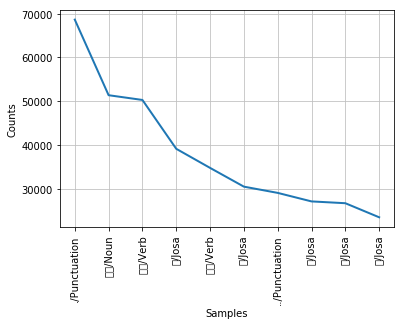

In [10]:
text.plot(10)

In [11]:
text_col = text.collocations() 

이/Determiner 것/Noun; 적/Suffix 인/Josa; 이/Determiner 거/Noun; 안/Noun
되다/Verb; 것/Noun 은/Josa; 10/Number 점/Noun; 배우/Noun 들/Suffix; 수/Noun
있다/Adjective; 이/Noun 게/Josa; 내/Noun 가/Josa; 최고/Noun 의/Josa; 네/Suffix
요/Josa; 이/Noun 영화/Noun; 끝/Noun 까지/Josa; 들/Suffix 이/Josa; 봐/Noun
도/Josa; 때문/Noun 에/Josa; 적/Suffix 으로/Josa; 사람/Noun 들/Suffix; 영화/Noun
를/Josa


## 3. Sentiment classification with term-existance

In [12]:
# 여기서는 최빈도 단어 2000개를 피쳐로 사용
# WARNING: 쉬운 이해를 위한 코드이며 time/memory efficient하지 않습니다
selected_words = [f[0] for f in text.vocab().most_common(2000)]
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

# 시간 단축을 위한 꼼수로 training corpus의 일부만 사용할 수 있음
train_docs = train_docs[:10000]

train_xy = [(term_exists(d), c) for d, c in train_docs]
test_xy = [(term_exists(d), c) for d, c in test_docs]

In [15]:
classifier = nltk.NaiveBayesClassifier.train(train_xy)
print(nltk.classify.accuracy(classifier, test_xy))

0.80416


In [16]:
classifier.show_most_informative_features(10)

Most Informative Features
         exists(수작/Noun) = True                1 : 0      =     38.0 : 1.0
         exists(최악/Noun) = True                0 : 1      =     30.1 : 1.0
       exists(♥/Foreign) = True                1 : 0      =     24.5 : 1.0
         exists(노잼/Noun) = True                0 : 1      =     22.1 : 1.0
         exists(낭비/Noun) = True                0 : 1      =     19.5 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     19.4 : 1.0
         exists(여운/Noun) = True                1 : 0      =     18.9 : 1.0
        exists(발연기/Noun) = True                0 : 1      =     16.9 : 1.0
          exists(굿/Noun) = True                1 : 0      =     16.9 : 1.0
        exists(최고다/Noun) = True                1 : 0      =     15.9 : 1.0


## 4. Sentiment classification with doc2vec

In [17]:
from collections import namedtuple
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
# 여기서는 15만개 training documents 전부 사용함
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [23]:
from gensim.models import doc2vec
# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)
# Train document vectors!
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, epochs=doc_vectorizer.iter, total_examples=doc_vectorizer.corpus_count)
    doc_vectorizer.alpha -= 0.002  # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # fix the learning rate, no decay
# To save
# doc_vectorizer.save('doc2vec.model')

In [24]:
pprint(doc_vectorizer.most_similar('공포/Noun'))

[('코믹/Noun', 0.4671582877635956),
 ('공포영화/Noun', 0.45561760663986206),
 ('한계/Noun', 0.4542228877544403),
 ('히어로/Noun', 0.45196518301963806),
 ('물/Noun', 0.4346657395362854),
 ('포드/Noun', 0.4346233010292053),
 ('진수/Noun', 0.4260939359664917),
 ('적절하다/Adjective', 0.4088713526725769),
 ('하이/Noun', 0.4071148931980133),
 ('sf/Alpha', 0.4066842496395111)]


In [25]:
pprint(doc_vectorizer.most_similar('ㅋㅋ/KoreanParticle'))

[('ㅋ/KoreanParticle', 0.44151800870895386),
 ('졸라/Noun', 0.33350422978401184),
 ('대박/Noun', 0.31741422414779663),
 ('빵/Noun', 0.31058913469314575),
 ('ㅡㅡ/KoreanParticle', 0.30521726608276367),
 ('.,/Punctuation', 0.30345433950424194),
 ('재밌다/Adjective', 0.303093284368515),
 ('하하/Noun', 0.28203365206718445),
 ('난리/Noun', 0.2819424569606781),
 ('참나/Noun', 0.28098636865615845)]


In [26]:
pprint(doc_vectorizer.most_similar(positive=['여자/Noun', '왕/Noun'], negative=['남자/Noun']))

[('유/Noun', 0.42781683802604675),
 ('무/Noun', 0.3866240084171295),
 ('맨/Noun', 0.38491952419281006),
 ('굿/Noun', 0.35985255241394043),
 ('그나마/Adverb', 0.34125086665153503),
 ('겁나다/Verb', 0.34070149064064026),
 ('졸라/Noun', 0.3393334150314331),
 ('ㄷ/KoreanParticle', 0.33886006474494934),
 ('~!!/Punctuation', 0.33542177081108093),
 ('엿/Noun', 0.32967323064804077)]


In [27]:
text.concordance('왕/Noun', lines=10)

Displaying 10 of 145 matches:
Josa 로맨스/Noun 냐/Josa ,,/Punctuation 왕/Noun 짜증/Noun ...../Punctuation 아주/Noun 전
/Noun 함/Noun ../Punctuation 결말/Noun 왕/Noun 실망/Noun 임/Noun 전작/Noun 에/Josa 비/Nou
nction 얼굴/Noun 만/Josa 예쁘다/Adjective 왕/Noun 되다/Verb 맞다/Verb 드라마/Noun 라도/Josa 도덕
/Noun 스릴러/Noun 임/Noun ?/Punctuation 왕/Noun 실망/Noun ./Punctuation 연기/Noun 대본/No
b 금/Noun 사인방/Noun ㅠㅠ/KoreanParticle 왕/Noun 잼/Noun 없다/Adjective ./Punctuation 정
osa 서유기/Noun 보다/Josa 희극/Noun 지/Josa 왕/Noun 이/Josa 더/Noun 최고/Noun 라/Josa 생각/Nou
접/Noun 한/Josa 걸작/Noun ./Punctuation 왕/Noun ,/Punctuation 너무/Noun 감동/Noun 적/Suf
Josa 온/Noun 거/Noun 처럼/Noun 제나라/Noun 왕/Noun 과/Josa 군사/Noun 들/Suffix 을/Josa 속이다/
다/Verb ./Punctuation 기대하다/Adjective 왕/Noun 지루/Noun .../Punctuation 제니퍼/Noun 틸리
tive 움/Noun 짜증/Noun .../Punctuation 왕/Noun 짜증/Noun ../Punctuation 사람/Noun 마다/J


In [29]:
# feature design
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
print(len(train_x))       # 사실 이 때문에 앞의 term existance와는 공평한 비교는 아닐 수 있다
# => 150000
print(len(train_x[0]))
# => 300
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]
print(len(test_x))
# => 50000
print(len(test_x[0]))
# => 300

10000
300
50000
300


In [30]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)

0.66684

## Reference

* Code: https://www.lucypark.kr/docs/2015-pyconkr
* Data: https://github.com/e9t/nsmc
* Tutorial: https://www.lucypark.kr/courses/2015-ba/text-mining.html#3-load-tokens-with-nltktext
* Book: http://www.nltk.org/book/ch06.html